### Die wichtigen Methoden, die ich für die Berechnungen nutze.

In [1]:
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
import os
import numpy as np
import statsmodels.stats.api as sms
from scipy.stats import ttest_ind


def getResult(y):
    with open(y, 'rb') as f:
        return pickle.load(f)

def getValues(r, region):
    return {
        'f1': r[region]['f1'],
        'accuracy': r[region]['accuracy'],
        'precision': r[region]['precision']
    }

def getDataFrame(path, region, name, index_value):
    x = getValues(getResult(path), region)
    return pd.DataFrame({name + '_f1': [x['f1']],
                         name + '_accuracy': [x['accuracy']],
                         name + '_precision': [x['precision']]},
                         index=[index_value])

def getDataFrameByDirectory(ranges, lookUp, name):
    dir = sorted(os.listdir(lookUp))
    df = pd.DataFrame()
    for idx in range(0,len(ranges)):
        df = pd.concat([df, getDataFrame(lookUp + '/' + dir[idx] + '/test_run.pkl', 'test', name, ranges[idx])])
    df.sort_index(inplace=True)
    return df

def plotByDataFrames(dataFrames, column, kind, index_condition=[], show_values=True, save_path='', create_mean=False , legend=False, legend_title=[], ymin=0, marker=False, **kwds):
    ax = plt.gca()
    plt.style.use('seaborn')
    df = pd.concat(dataFrames, axis=1, join='inner')
    if not index_condition:
        index_condition = df.index
    columns = [x for i, x in enumerate(df.columns) if x.endswith(column)]
    if create_mean:
        mean = df[columns].loc[df.index.isin(index_condition)].mean()
        (down, top) = sms.DescrStatsW(df[columns]).tconfint_mean()
        if kind=='bar':
            mean.plot(kind=kind,  y=[x.split('__')[1].split('_')[0] for x in columns],yerr=[[mean-down, top-mean]], title=column, ax=ax, **kwds)
            if show_values:
                for i,p in enumerate(ax.patches):
                    ax.annotate(str(round(top[i],1)), ((p.get_x() * 1.005, p.get_height() * 1.005-0.1)))
                    ax.annotate(str(round(down[i],1)), ((p.get_x() * 1.005, p.get_height() * 1.005-0.15)))
                    
        else:
            if not marker:
                marker = 'o'
            y = pd.DataFrame({'mean': [m * 100 for m in mean], 'idx': [x.split('__')[1].split('_')[0] for x in columns]})
            y = y.set_index('idx')
            y['mean'].plot(x=y.index,  title=column, ax=ax,marker=marker,  **kwds)
            ax.fill_between(y.index, [d * 100 for d in down], [t * 100 for t in top], alpha=0.2, **kwds)

    else:
        pd.DataFrame(df.loc[df.index.isin(index_condition)]*100).plot(kind=kind, y=columns, title=column, ax=ax, **kwds)
    if show_values:
        for p in ax.patches:
            ax.annotate(str(round(p.get_height(), 1)), (p.get_x() * 1.005, p.get_height() * 1.005))
    if not legend_title:
        legend_title = [label.replace('_' + column, '').replace('_', ' ') for label in columns]
    if legend:
        l = plt.legend(labels=legend_title, loc = 'lower right', frameon=True)
        frame = l.get_frame()
        frame.set_facecolor('white')
    if ymin >0:
        ax.set_ylim(auto=True, ymin=ymin*100)    
    plt.xlabel('% of trainings data')
    plt.ylabel(column + ' in %')
    if  save_path:
        plt.savefig('./plots/' + save_path)
    
    if not create_mean:
        plt.show()
        
def significantTest(x, y):
    # X:
    (tx,dx) = sms.DescrStatsW(x).tconfint_mean()
    mx = pd.DataFrame(x).mean()
    print('x=' + str(np.floor(mx[0]*1000)/1000) + '+-' + str(np.floor(1000*(mx[0]-tx))/1000))
    
    (ty,dy) = sms.DescrStatsW(y).tconfint_mean()
    my = pd.DataFrame(y).mean()
    print('y=' + str(np.floor(my[0]*1000)/1000) + '+-' +  str(np.floor(1000*(my[0]-ty))/1000))

    
    stat, p = ttest_ind(x, y)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')


In [3]:
import math
import random


def getPercOfStoriesDir(direc, perc):
    dir = [x for x in sorted(os.listdir(direc)) if x.endswith('.md')]
    stories = ''
    for i in range(0, len(dir)):
        stories += getPercOfStoriesFile(direc + '/' + dir[i], perc)
    return stories

def getPercOfStoriesFile(path, perc):
    with open(path, 'rb') as file:
        content = str(file.read())
        splitted_stories = ['##' + story for story in content.split('##')][1::]
        
        number_of_stories = round(len(splitted_stories)*perc)
        stories = ''
        for i in range(0, number_of_stories):
            stories += random.choice(splitted_stories)
        return stories
    

def createNewFiles(source_dir, dest_dir, perc, num):
    for i in range(0,num):
        x = getPercOfStoriesDir(source_dir, perc).replace('\\n', '\n')
        file = open(dest_dir + '/stories_' + str(round(perc * 100)) + '-' + str(i + 1) + '.md', 'w')
        file.write(x)

# 7.1 Supervised Learning 
## 7.1.1 Vertauschung

### Korpus: MultiWOZ

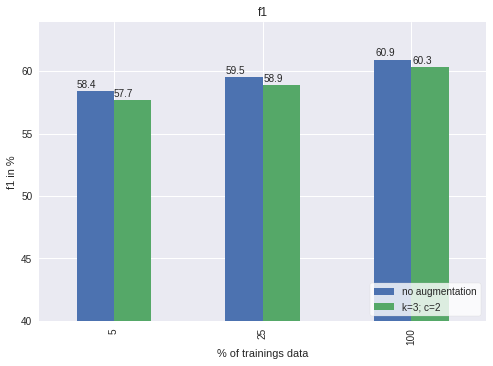

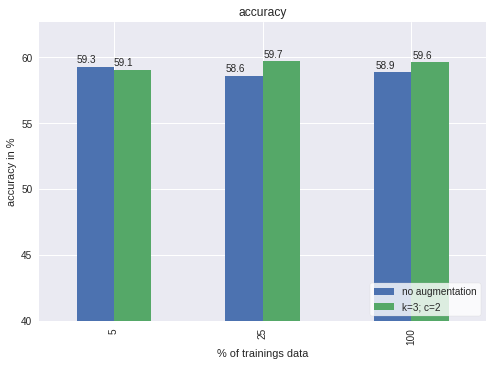

In [3]:
multiWOZ_only = getDataFrameByDirectory([5,25,50,70,95,100], './dataFrames/00_only/multiWOZ_only', 'no augmentation')
multiWOZ_b3_c2 = getDataFrameByDirectory([5,25,50,70,95,100], './dataFrames/01_blocks/multiWOZ_blocks_3_copies_2', 'k=3;_c=2')
plotByDataFrames([multiWOZ_only, multiWOZ_b3_c2], 'f1', 'bar', [25, 5, 100], show_values=True, create_mean=False, legend=True, ymin=0.4, save_path='multiWOZ_accuracy')
plotByDataFrames([multiWOZ_only, multiWOZ_b3_c2], 'accuracy', 'bar', [25, 5, 100], show_values=True, create_mean=False, legend=True, ymin=0.4, save_path='multiWOZ_f1')

### Korpus: Generierte Daten

Unterschiedliche Anzahl an Blöcken bei identischer Anzahl Kopien

In [2]:
only = getDataFrameByDirectory([100,25,5], './dataFrames/00_only/only', 'no_augmentation')

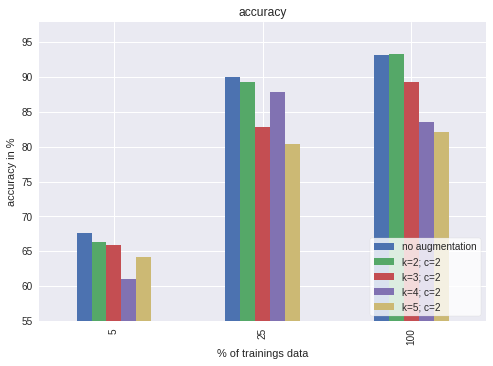

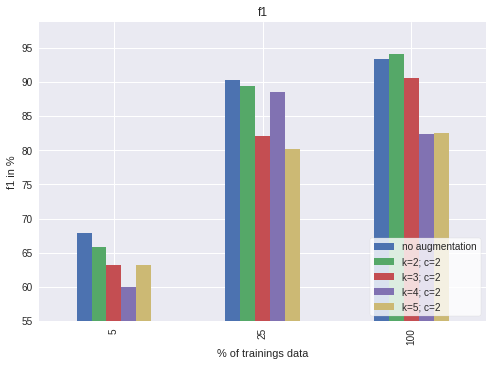

In [90]:
b2_c2 = getDataFrameByDirectory([100, 25, 5], './dataFrames/01_blocks/blocks_2_copies_2', 'k=2;_c=2')
b3_c2 = getDataFrameByDirectory([100, 5,25], './dataFrames/01_blocks/blocks_3_copies_2', 'k=3;_c=2')
b4_c2 = getDataFrameByDirectory([100, 5, 25], './dataFrames/01_blocks/blocks_4_copies_2', 'k=4;_c=2')
b5_c2 = getDataFrameByDirectory([100, 5, 25], './dataFrames/01_blocks/blocks_5_copies_2', 'k=5;_c=2')
plotByDataFrames([only, b2_c2, b3_c2, b4_c2, b5_c2], 'accuracy', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.55, save_path='embedding_blocks_2-5_copies_2_accuracy')
plotByDataFrames([only, b2_c2, b3_c2, b4_c2, b5_c2], 'f1', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.55, save_path='embedding_blocks_2-5_copies_2_f1')

Unterschiedliche Anzahl Kopien bei identischer Anzahl an Blöcken

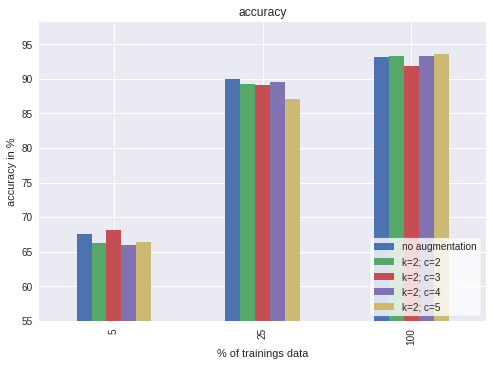

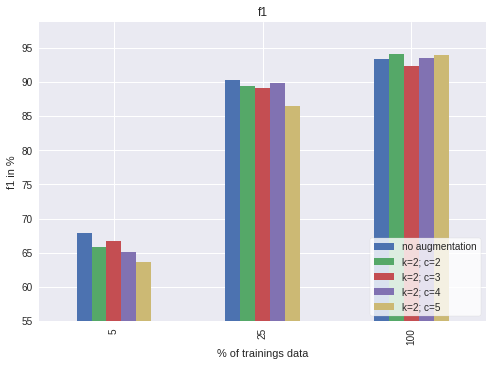

In [92]:
b2_c3 = getDataFrameByDirectory([100, 5, 25], './dataFrames/01_blocks/blocks_2_copies_3', 'k=2;_c=3')
b2_c4 = getDataFrameByDirectory([100, 5, 25], './dataFrames/01_blocks/blocks_2_copies_4', 'k=2;_c=4')
b2_c5 = getDataFrameByDirectory([100, 5, 25], './dataFrames/01_blocks/blocks_2_copies_5', 'k=2;_c=5')
plotByDataFrames([only, b2_c2, b2_c3, b2_c4, b2_c5], 'accuracy', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.55, save_path='embedding_blocks_2_copies_2-5_accuracy')
plotByDataFrames([only, b2_c2, b2_c3, b2_c4, b2_c5], 'f1', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.55, save_path='embedding_blocks_2_copies_2-5_f1')

Konfidenzintervalle von 2 Blöcken und 2 Kopien im Vergleich zu Baseline

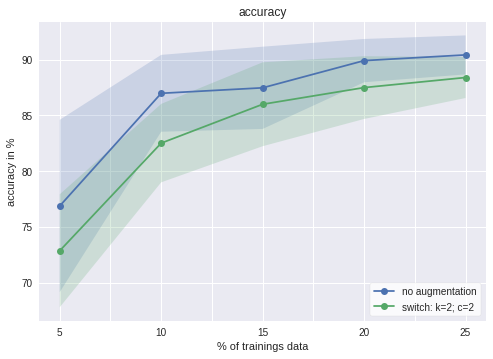

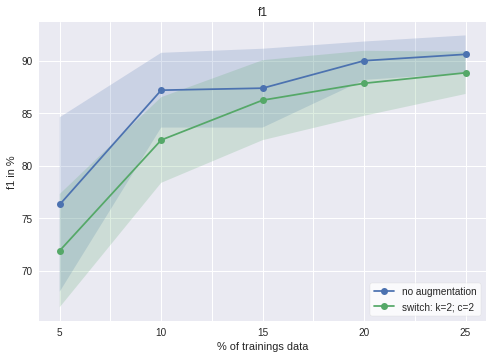

In [11]:
only_5pr_conf = getDataFrameByDirectory([1,2, 3,4,5,6], './dataFrames/00_only/only_5pr_conf', 'no_augmentation__5')
only_10pr_conf = getDataFrameByDirectory([1,2, 3,4,5], './dataFrames/00_only/only_10pr_conf', 'no_augmentation__10')
only_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_15pr_conf', 'no_augmentation__15')
only_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_20pr_conf', 'no_augmentation__20')
only_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_25pr_conf', 'no_augmentation__25')
only_100pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_100pr_conf', 'no_augmentation__100') 


b2_c2_5pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/01_blocks/blocks_2_copies_2_5pr_conf', '2_blocks_2_copies__5_conf')
b2_c2_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/01_blocks/blocks_2_copies_2_10pr_conf', '2_blocks_2_copies__10_conf')
b2_c2_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/01_blocks/blocks_2_copies_2_15pr_conf', '2_blocks_2_copies__15_conf')
b2_c2_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/01_blocks/blocks_2_copies_2_20pr_conf', '2_blocks_2_copies__20_conf')
b2_c2_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/01_blocks/blocks_2_copies_2_25pr_conf', '2_blocks_2_copies__25_conf')

plotByDataFrames([only_5pr_conf, only_10pr_conf, only_15pr_conf, only_20pr_conf, only_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([b2_c2_5pr_conf, b2_c2_10pr_conf, b2_c2_15pr_conf, b2_c2_20pr_conf, b2_c2_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True,legend_title=['no augmentation', 'switch: k=2; c=2'], save_path='embedding_blocks_graph_accuracy')
plt.show()
plotByDataFrames([only_5pr_conf, only_10pr_conf, only_15pr_conf, only_20pr_conf, only_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([b2_c2_5pr_conf, b2_c2_10pr_conf, b2_c2_15pr_conf, b2_c2_20pr_conf, b2_c2_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True,legend_title=['no augmentation', 'switch: k=2; c=2'], save_path='embedding_blocks_graph_f1')


## 7.1.2 Einfügen von Chitchat

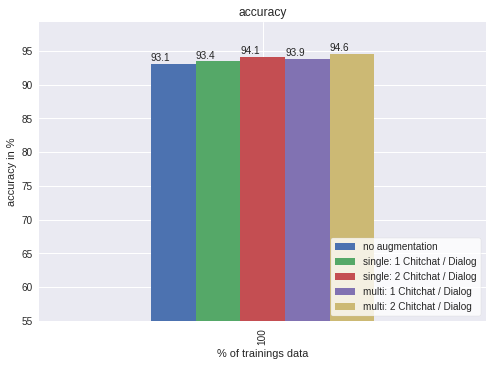

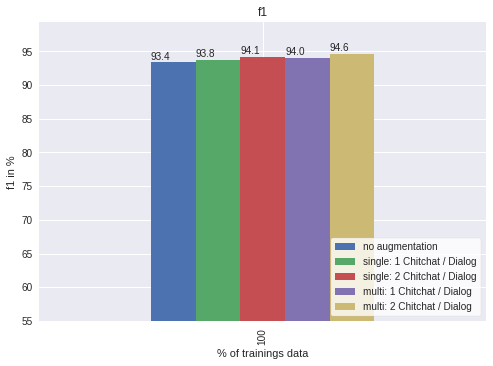

In [139]:
single_of_s1_c1 = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/single_original_f_copies_1_stories_1', 'single:_1_Chitchat_/_Dialog')
single_of_s2_c1 = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/single_original_f_copies_1_stories_2', 'single:_2_Chitchat_/_Dialog')
multi_c1_s1_cf = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/multi_original_f_copies_1_stories_1', 'multi:_1_Chitchat_/_Dialog')
multi_c1_s2_cf = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/multi_original_f_copies_1_stories_2', 'multi:_2_Chitchat_/_Dialog')
plotByDataFrames([only, single_of_s1_c1, single_of_s2_c1, multi_c1_s1_cf, multi_c1_s2_cf], 'accuracy', 'bar', [100], show_values=True, create_mean=False, legend=True, ymin=0.55)
plotByDataFrames([only, single_of_s1_c1, single_of_s2_c1, multi_c1_s1_cf, multi_c1_s2_cf], 'f1', 'bar', [100], show_values=True, create_mean=False, legend=True, ymin=0.55)

Jetzt ist festzustellen, ob `single: 1 Chitchat/Dialog` 25% signifikant ist, oder nicht?

$F_1$ Wert für 25% der Daten

In [11]:
single_of_s1_c1_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/02_chitchat/single_original_f_copies_1_stories_1_25pr_conf', 'single:_1_Chitchat_/_Dialog__25_conf')
significantTest(only_25pr_conf['no_augmentation__25_f1'],single_of_s1_c1_25pr_conf['single:_1_Chitchat_/_Dialog__25_conf_f1'])

x=0.906+-0.018
y=0.918+-0.018
stat=-1.302, p=0.229
Probably the same distribution


In [12]:
significantTest(only_25pr_conf['no_augmentation__25_accuracy'],single_of_s1_c1_25pr_conf['single:_1_Chitchat_/_Dialog__25_conf_accuracy'])

x=0.904+-0.017
y=0.916+-0.017
stat=-1.324, p=0.222
Probably the same distribution


**Single:** Mit Original Dialogen und 1-2 Kopien 

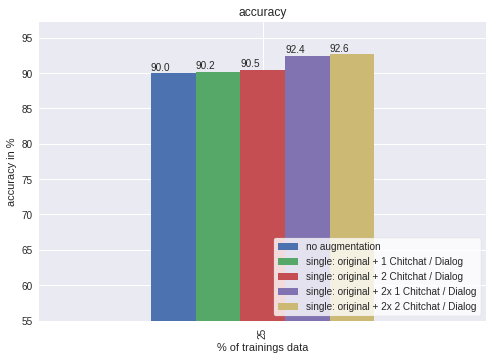

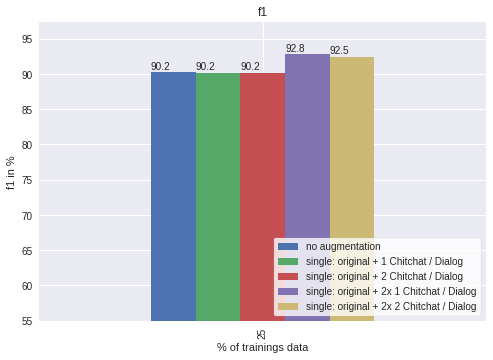

In [52]:
single_ot_s1_c1 = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/single_original_t_copies_1_stories_1', 'single:_original_+_1_Chitchat_/_Dialog')
single_ot_s2_c1 = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/single_original_t_copies_1_stories_2', 'single:_original_+_2_Chitchat_/_Dialog')
single_ot_s1_c2 = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/single_original_t_copies_2_stories_1', 'single:_original_+_2x_1_Chitchat_/_Dialog')
single_ot_s2_c2 = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/single_original_t_copies_2_stories_2', 'single:_original_+_2x_2_Chitchat_/_Dialog')
plotByDataFrames([only, single_ot_s1_c1, single_ot_s2_c1, single_ot_s1_c2, single_ot_s2_c2], 'accuracy', 'bar', [25], show_values=True, create_mean=False, legend=True, ymin=0.55)
plotByDataFrames([only, single_ot_s1_c1, single_ot_s2_c1, single_ot_s1_c2, single_ot_s2_c2], 'f1', 'bar', [25],show_values=True, create_mean=False, legend=True, ymin=0.55)

**Multi:** Mit Original Dialogen und 1-2 Kopien

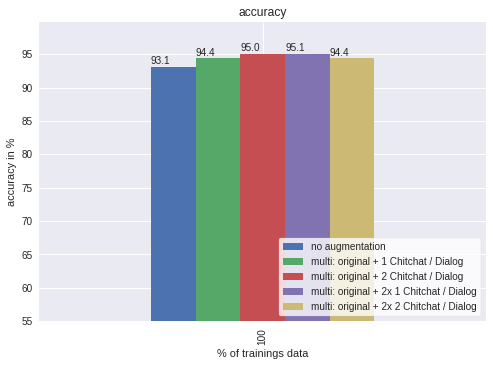

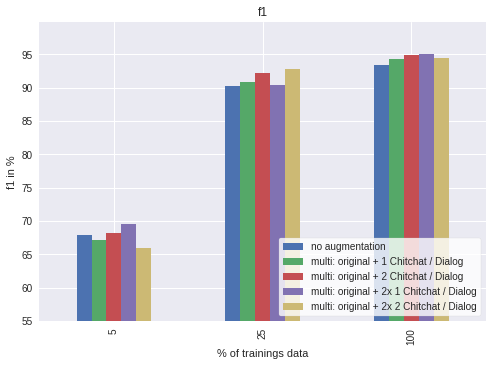

In [142]:
multi_ot_s1_c1 = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/multi_original_t_copies_1_stories_1', 'multi:_original_+_1_Chitchat_/_Dialog')
multi_ot_s2_c1 = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/multi_original_t_copies_1_stories_2', 'multi:_original_+_2_Chitchat_/_Dialog')
multi_ot_s1_c2 = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/multi_original_t_copies_2_stories_1', 'multi:_original_+_2x_1_Chitchat_/_Dialog')
multi_ot_s2_c2 = getDataFrameByDirectory([5,25,100], 'dataFrames/02_chitchat/multi_original_t_copies_2_stories_2', 'multi:_original_+_2x_2_Chitchat_/_Dialog')
plotByDataFrames([only, multi_ot_s1_c1, multi_ot_s2_c1, multi_ot_s1_c2, multi_ot_s2_c2], 'accuracy', 'bar', [100], show_values=True, create_mean=False, legend=True, ymin=0.55)
plotByDataFrames([only, multi_ot_s1_c1, multi_ot_s2_c1, multi_ot_s1_c2, multi_ot_s2_c2], 'f1', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.55)

Konfidenzintervalle für `single: Original TRUE + 2x 1 CC/Dialog`

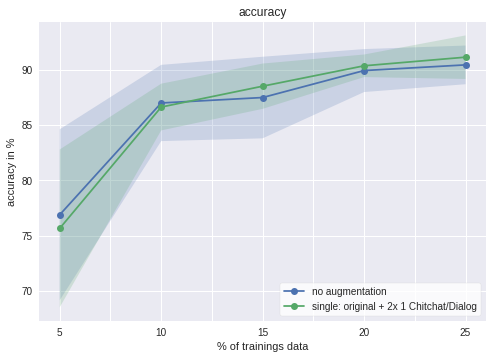

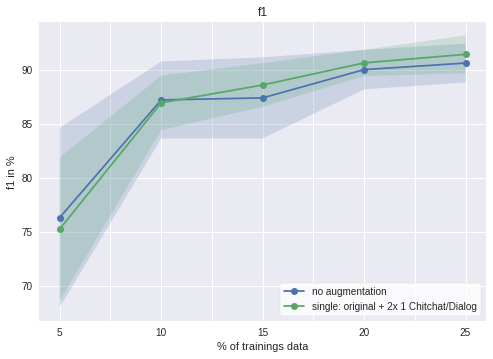

In [12]:
single_c2_s1_5pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/02_chitchat/single_original_t_copies_2_stories_1_5pr_conf', 's_c2_s2__5_conf')
single_c2_s1_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/02_chitchat/single_original_t_copies_2_stories_1_10pr_conf', 's_c2_s2__10_conf')
single_c2_s1_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/02_chitchat/single_original_t_copies_2_stories_1_15pr_conf', 's_c2_s2__15_conf')
single_c2_s1_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/02_chitchat/single_original_t_copies_2_stories_1_20pr_conf', 's_c2_s2__20_conf')
single_c2_s1_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/02_chitchat/single_original_t_copies_2_stories_1_25pr_conf', 's_c2_s2__25_conf')
plotByDataFrames([only_5pr_conf, only_10pr_conf, only_15pr_conf, only_20pr_conf, only_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([single_c2_s1_5pr_conf, single_c2_s1_10pr_conf, single_c2_s1_15pr_conf, single_c2_s1_20pr_conf, single_c2_s1_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True,legend_title=['no augmentation', 'single: original + 2x 1 Chitchat/Dialog'], save_path='embedding_single_graph_accuracy')
plt.show()
plotByDataFrames([only_5pr_conf, only_10pr_conf, only_15pr_conf, only_20pr_conf, only_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([single_c2_s1_5pr_conf, single_c2_s1_10pr_conf, single_c2_s1_15pr_conf, single_c2_s1_20pr_conf, single_c2_s1_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True,legend_title=['no augmentation', 'single: original + 2x 1 Chitchat/Dialog'], save_path='embedding_single_graph_f1')

Konfidenzintervalle, wie oben mit Rückführung

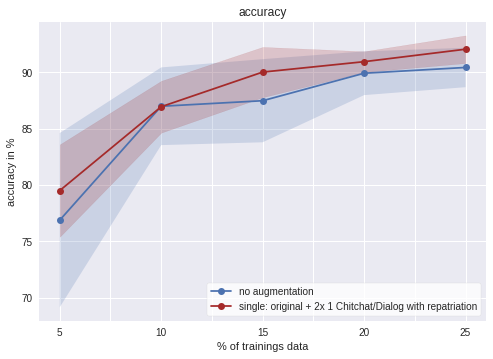

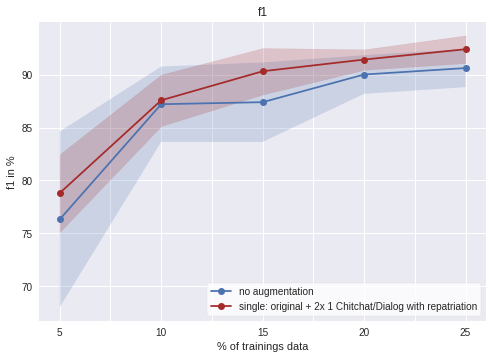

In [13]:
single_ot_s1_c2_ct_5pr = getDataFrameByDirectory([1,2,3,4,5], 'dataFrames/02_chitchat/single_original_t_copies_1_cons_t_5pr_conf', 'single_ot_s1_c2_cons_t__5_conf')
single_ot_s1_c2_ct_10pr = getDataFrameByDirectory([1,2,3,4,5], 'dataFrames/02_chitchat/single_original_t_copies_1_cons_t_10pr_conf', 'single_ot_s1_c2_cons_t__10_conf')
single_ot_s1_c2_ct_15pr = getDataFrameByDirectory([1,2,3,4,5], 'dataFrames/02_chitchat/single_original_t_copies_1_cons_t_15pr_conf', 'single_ot_s1_c2_cons_t__15_conf')
single_ot_s1_c2_ct_20pr = getDataFrameByDirectory([1,2,3,4,5], 'dataFrames/02_chitchat/single_original_t_copies_1_cons_t_20pr_conf', 'single_ot_s1_c2_cons_t__20_conf')
single_ot_s1_c2_ct_25pr = getDataFrameByDirectory([1,2,3,4,5], 'dataFrames/02_chitchat/single_original_t_copies_1_cons_t_25pr_conf', 'single_ot_s1_c2_cons_t__25_conf')
plotByDataFrames([only_5pr_conf, only_10pr_conf, only_15pr_conf, only_20pr_conf, only_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([single_ot_s1_c2_ct_5pr, single_ot_s1_c2_ct_10pr, single_ot_s1_c2_ct_15pr, single_ot_s1_c2_ct_20pr, single_ot_s1_c2_ct_25pr], 'accuracy', 'line', show_values=False, legend=True, create_mean=True,legend_title=['no augmentation', 'single: original + 2x 1 Chitchat/Dialog with repatriation'], color='brown', save_path='embedding_single_with_repatriation_accuracy')
plt.show()
plotByDataFrames([only_5pr_conf, only_10pr_conf, only_15pr_conf, only_20pr_conf, only_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([single_ot_s1_c2_ct_5pr, single_ot_s1_c2_ct_10pr, single_ot_s1_c2_ct_15pr, single_ot_s1_c2_ct_20pr, single_ot_s1_c2_ct_25pr], 'f1', 'line', show_values=False, legend=True, create_mean=True,legend_title=['no augmentation', 'single: original + 2x 1 Chitchat/Dialog with repatriation'], color='brown', save_path='embedding_single_with_repatriation_f1')


$F_1$ Wert bei 15\%

In [17]:
significantTest(only_15pr_conf['no_augmentation__15_f1'],single_ot_s1_c2_ct_15pr['single_ot_s1_c2_cons_t__15_conf_f1'])

x=0.873+-0.037
y=0.903+-0.021
stat=-1.867, p=0.099
Probably the same distribution


`Accuracy` bei 15\%

In [18]:
significantTest(only_15pr_conf['no_augmentation__15_accuracy'],single_ot_s1_c2_ct_15pr['single_ot_s1_c2_cons_t__15_conf_accuracy'])

x=0.874+-0.036
y=0.9+-0.022
stat=-1.637, p=0.140
Probably the same distribution


$F_1$ Wert bei 20\%

In [19]:
significantTest(only_20pr_conf['no_augmentation__20_f1'],single_ot_s1_c2_ct_20pr['single_ot_s1_c2_cons_t__20_conf_f1'])

x=0.9+-0.018
y=0.914+-0.009
stat=-1.898, p=0.094
Probably the same distribution


`Accuracy` bei 20\%

In [20]:
significantTest(only_20pr_conf['no_augmentation__20_accuracy'],single_ot_s1_c2_ct_20pr['single_ot_s1_c2_cons_t__20_conf_accuracy'])

x=0.899+-0.019
y=0.909+-0.009
stat=-1.324, p=0.222
Probably the same distribution


$F_1$ Wert bei 25\%

In [21]:
significantTest(only_25pr_conf['no_augmentation__25_f1'],single_ot_s1_c2_ct_25pr['single_ot_s1_c2_cons_t__25_conf_f1'])

x=0.906+-0.018
y=0.924+-0.013
stat=-2.226, p=0.057
Probably the same distribution


`Accuracy` bei 25\%

In [22]:
significantTest(only_25pr_conf['no_augmentation__25_accuracy'],single_ot_s1_c2_ct_25pr['single_ot_s1_c2_cons_t__25_conf_accuracy'])

x=0.904+-0.017
y=0.92+-0.012
stat=-2.106, p=0.068
Probably the same distribution


### Ablation Study
**Epoch-Problem** 
Zunächst wird ein Signifikanztest für die Augmentierung mit 33 Epochen durchgeführt. 

In [9]:
single_ot_s1_c2_ct_33epoch_25pr = getDataFrameByDirectory([1,2,3,4,5], 'dataFrames/02_chitchat/single_original_t_copies_2_stories_1_33epoch_25pr_conf', 'single_ot_s1_c2_cons_t_33epoch__25_conf')
significantTest(only_25pr_conf['no_augmentation__25_f1'],single_ot_s1_c2_ct_33epoch_25pr['single_ot_s1_c2_cons_t_33epoch__25_conf_f1'])

x=0.906+-0.018
y=0.888+-0.047
stat=0.940, p=0.375
Probably the same distribution


In [10]:
single_ot_s1_c2_ct_33epoch_20pr = getDataFrameByDirectory([1,2,3,4,5], 'dataFrames/02_chitchat/single_original_t_copies_2_stories_1_33epoch_20pr_conf', 'single_ot_s1_c2_cons_t_33epoch__20_conf')
significantTest(only_25pr_conf['no_augmentation__25_f1'],single_ot_s1_c2_ct_33epoch_20pr['single_ot_s1_c2_cons_t_33epoch__20_conf_f1'])

x=0.906+-0.018
y=0.889+-0.029
stat=1.375, p=0.206
Probably the same distribution


Im weiteren Werde ich mir anschauen, wie die Ergebnisse von Only mit 300 Epochen aussehen, ob sich das selbe Bild zeichnet.

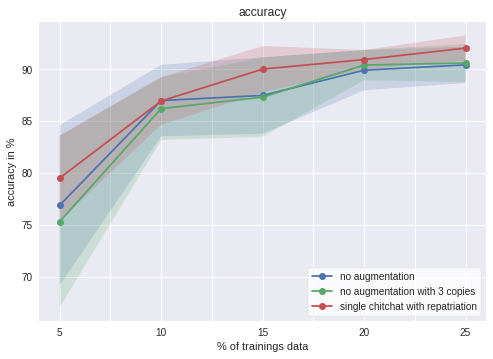

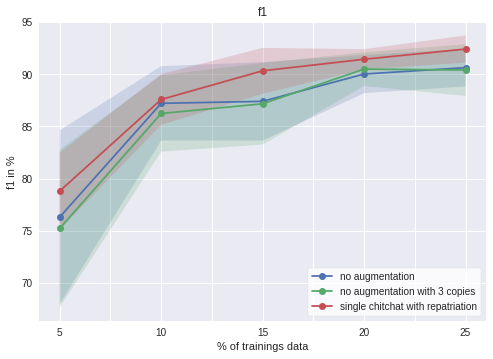

In [15]:
only_300_epochs_5pr_conf = getDataFrameByDirectory([1,2,3,4 ,5], './dataFrames/00_only/only_300_epochs_5pr_conf', 'no_augmentation_300_epochs__5')
only_300_epochs_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_300_epochs_10pr_conf', 'no_augmentation_300_epochs__10')
only_300_epochs_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_300_epochs_15pr_conf', 'no_augmentation_300_epochs__15')
only_300_epochs_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_300_epochs_20pr_conf', 'no_augmentation_300_epochs__20')
only_300_epochs_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_300_epochs_25pr_conf', 'no_augmentation_300_epochs__25')

only_3_copies_5pr_conf = getDataFrameByDirectory([1,2,3,4 ,5], './dataFrames/00_only/only_3copies_5pr_conf', 'no_augmentation_3c__5')
only_3_copies_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_3copies_10pr_conf', 'no_augmentation_3c__10')
only_3_copies_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_3copies_15pr_conf', 'no_augmentation_3c__15')
only_3_copies_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_3copies_20pr_conf', 'no_augmentation_3c__20')
only_3_copies_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/00_only/only_3copies_25pr_conf', 'no_augmentation_3c__25')


plotByDataFrames([only_5pr_conf, only_10pr_conf, only_15pr_conf, only_20pr_conf, only_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
#plotByDataFrames([only_300_epochs_5pr_conf, only_300_epochs_10pr_conf, only_300_epochs_15pr_conf, only_300_epochs_20pr_conf, only_300_epochs_25pr_conf], 'accuracy', 'line', show_values=False, create_mean=True)
plotByDataFrames([only_3_copies_5pr_conf, only_3_copies_10pr_conf, only_3_copies_15pr_conf, only_3_copies_20pr_conf, only_3_copies_25pr_conf], 'accuracy', 'line', show_values=False, create_mean=True)
plotByDataFrames([single_ot_s1_c2_ct_5pr, single_ot_s1_c2_ct_10pr, single_ot_s1_c2_ct_15pr, single_ot_s1_c2_ct_20pr, single_ot_s1_c2_ct_25pr], 'accuracy', 'line', show_values=False, legend=True, create_mean=True,legend_title=['no augmentation',  'no augmentation with 3 copies','single chitchat with repatriation'], save_path='chitchat_ablation-accuracy')
plt.show()
plotByDataFrames([only_5pr_conf, only_10pr_conf, only_15pr_conf, only_20pr_conf, only_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
#plotByDataFrames([only_300_epochs_5pr_conf, only_300_epochs_10pr_conf, only_300_epochs_15pr_conf, only_300_epochs_20pr_conf, only_300_epochs_25pr_conf], 'f1', 'line', show_values=False, create_mean=True)
plotByDataFrames([only_3_copies_5pr_conf, only_3_copies_10pr_conf, only_3_copies_15pr_conf, only_3_copies_20pr_conf, only_3_copies_25pr_conf], 'f1', 'line', show_values=False, create_mean=True)
plotByDataFrames([single_ot_s1_c2_ct_5pr, single_ot_s1_c2_ct_10pr, single_ot_s1_c2_ct_15pr, single_ot_s1_c2_ct_20pr, single_ot_s1_c2_ct_25pr], 'f1', 'line', show_values=False, legend=True, create_mean=True,legend_title=['no augmentation',  'no augmentation with 3 copies', 'single chitchat with repatriation'] , save_path='chitchat_ablation-f1')

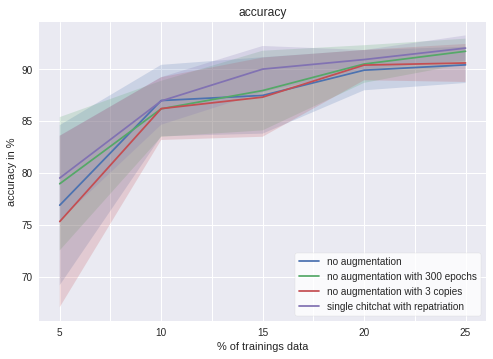

In [16]:
plotByDataFrames([only_5pr_conf, only_10pr_conf, only_15pr_conf, only_20pr_conf, only_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([only_300_epochs_5pr_conf, only_300_epochs_10pr_conf, only_300_epochs_15pr_conf, only_300_epochs_20pr_conf, only_300_epochs_25pr_conf], 'accuracy', 'line', show_values=False, create_mean=True)
plotByDataFrames([only_3_copies_5pr_conf, only_3_copies_10pr_conf, only_3_copies_15pr_conf, only_3_copies_20pr_conf, only_3_copies_25pr_conf], 'accuracy', 'line', show_values=False, create_mean=True)
plotByDataFrames([single_ot_s1_c2_ct_5pr, single_ot_s1_c2_ct_10pr, single_ot_s1_c2_ct_15pr, single_ot_s1_c2_ct_20pr, single_ot_s1_c2_ct_25pr], 'accuracy', 'line', show_values=False, legend=True, create_mean=True,legend_title=['no augmentation', 'no augmentation with 300 epochs', 'no augmentation with 3 copies','single chitchat with repatriation'], save_path='chitchat_ablation-accuracy')

### 7.1.3 Generierung neuer Dialoge

Generierung mit fixer Länge und variablen Multiplikationsfaktor und ohne Zufall

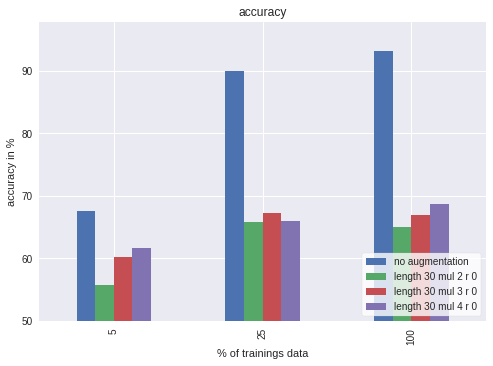

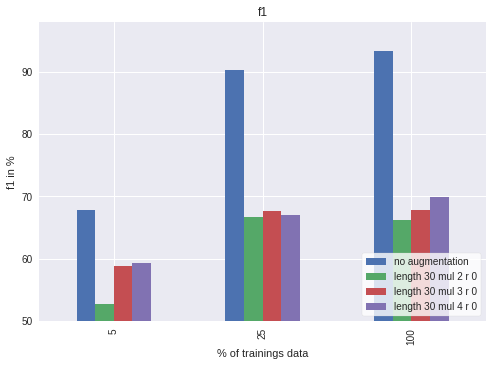

In [42]:
new_l30_m2_r0 = getDataFrameByDirectory([5,25,100], 'dataFrames/03_new/new_l30_m2_s0', 'length_30_mul_2_r_0')
new_l30_m3_r0 = getDataFrameByDirectory([5,25,100], 'dataFrames/03_new/new_l30_m3_s0', 'length_30_mul_3_r_0')
new_l30_m4_r0 = getDataFrameByDirectory([5,25,100], 'dataFrames/03_new/new_l30_m4_s0', 'length_30_mul_4_r_0')
plotByDataFrames([only, new_l30_m2_r0, new_l30_m3_r0, new_l30_m4_r0], 'accuracy', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.5, save_path='embedding_new_l30_m2-4_r0_not_ot-accuracy.png')
plotByDataFrames([only, new_l30_m2_r0, new_l30_m3_r0, new_l30_m4_r0], 'f1', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.5, save_path='embedding_new_l30_m2-4_r0_not_ot-f1.png')

Test der Verbesserung bei zunehmender Datenmenge für ``length 30 mul 2 r 0``(grün)

In [37]:
new_l30_m2_r0_5pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/03_new/new_l30_m2_s0_5pr_conf', 'new_l30_m2_s0__5')
new_l30_m2_r0_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/03_new/new_l30_m2_s0_25pr_conf', 'new_l30_m2_s0__25')
new_l30_m2_r0_100pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/03_new/new_l30_m2_s0_100pr_conf', 'new_l30_m2_s0__100')

significantTest(new_l30_m2_r0_5pr_conf['new_l30_m2_s0__5_accuracy'],new_l30_m2_r0_25pr_conf['new_l30_m2_s0__25_accuracy'])
significantTest(new_l30_m2_r0_25pr_conf['new_l30_m2_s0__25_accuracy'],new_l30_m2_r0_100pr_conf['new_l30_m2_s0__100_accuracy'])
significantTest(new_l30_m2_r0_5pr_conf['new_l30_m2_s0__5_accuracy'],new_l30_m2_r0_100pr_conf['new_l30_m2_s0__100_accuracy'])

x=0.623+-0.038
y=0.654+-0.028
stat=-1.810, p=0.108
Probably the same distribution
x=0.654+-0.028
y=0.65+-0.012
stat=0.346, p=0.738
Probably the same distribution
x=0.623+-0.038
y=0.65+-0.012
stat=-1.881, p=0.097
Probably the same distribution


In [38]:
significantTest(new_l30_m2_r0_5pr_conf['new_l30_m2_s0__5_f1'],new_l30_m2_r0_25pr_conf['new_l30_m2_s0__25_f1'])
significantTest(new_l30_m2_r0_25pr_conf['new_l30_m2_s0__25_f1'],new_l30_m2_r0_100pr_conf['new_l30_m2_s0__100_f1'])
significantTest(new_l30_m2_r0_5pr_conf['new_l30_m2_s0__5_f1'],new_l30_m2_r0_100pr_conf['new_l30_m2_s0__100_f1'])

x=0.62+-0.026
y=0.654+-0.041
stat=-1.888, p=0.096
Probably the same distribution
x=0.654+-0.041
y=0.664+-0.009
stat=-0.706, p=0.500
Probably the same distribution
x=0.62+-0.026
y=0.664+-0.009
stat=-4.345, p=0.002
Probably different distributions


Test der Verbesserung bei zunehmender Datenmenge für ``length 30 mul 4 r 0``(lila)

In [39]:
new_l30_m4_r0_5pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/03_new/new_l30_m4_s0_5pr_conf', 'new_l30_m4_s0__5')
new_l30_m4_r0_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/03_new/new_l30_m4_s0_25pr_conf', 'new_l30_m4_s0__25')
new_l30_m4_r0_100pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/03_new/new_l30_m4_s0_100pr_conf', 'new_l30_m4_s0__100')

significantTest(new_l30_m4_r0_5pr_conf['new_l30_m4_s0__5_accuracy'],new_l30_m4_r0_25pr_conf['new_l30_m4_s0__25_accuracy'])
significantTest(new_l30_m4_r0_25pr_conf['new_l30_m4_s0__25_accuracy'],new_l30_m4_r0_100pr_conf['new_l30_m4_s0__100_accuracy'])
significantTest(new_l30_m4_r0_5pr_conf['new_l30_m4_s0__5_accuracy'],new_l30_m4_r0_100pr_conf['new_l30_m4_s0__100_accuracy'])

x=0.627+-0.046
y=0.653+-0.029
stat=-1.317, p=0.224
Probably the same distribution
x=0.653+-0.029
y=0.677+-0.024
stat=-1.718, p=0.124
Probably the same distribution
x=0.627+-0.046
y=0.677+-0.024
stat=-2.639, p=0.030
Probably different distributions


In [40]:
significantTest(new_l30_m4_r0_5pr_conf['new_l30_m4_s0__5_f1'],new_l30_m4_r0_25pr_conf['new_l30_m4_s0__25_f1'])
significantTest(new_l30_m4_r0_25pr_conf['new_l30_m4_s0__25_f1'],new_l30_m4_r0_100pr_conf['new_l30_m4_s0__100_f1'])
significantTest(new_l30_m4_r0_5pr_conf['new_l30_m4_s0__5_f1'],new_l30_m4_r0_100pr_conf['new_l30_m4_s0__100_f1'])

x=0.62+-0.047
y=0.659+-0.033
stat=-1.873, p=0.098
Probably the same distribution
x=0.659+-0.033
y=0.686+-0.019
stat=-1.896, p=0.095
Probably the same distribution
x=0.62+-0.047
y=0.686+-0.019
stat=-3.569, p=0.007
Probably different distributions


In [45]:
significantTest(only_5pr_conf['no_augmentation__5_accuracy'],only_100pr_conf['no_augmentation__100_accuracy'])

x=0.753+-0.07
y=0.936+-0.005
stat=-6.013, p=0.000
Probably different distributions


Generierung mit variabler Länge und fixem Multiplikationsfaktor

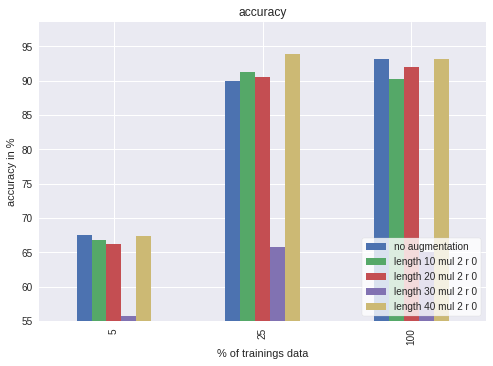

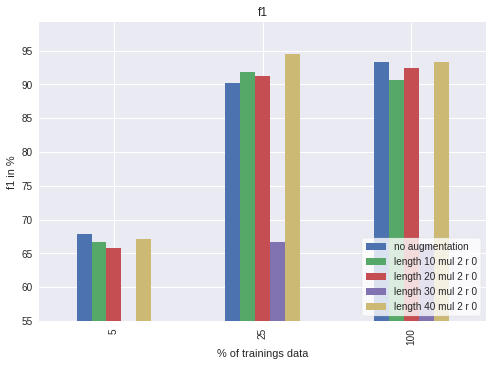

In [43]:
new_l10_m2_r0 = getDataFrameByDirectory([5,25,100], 'dataFrames/03_new/new_l10_m2_s0', 'length_10_mul_2_r_0')
new_l20_m2_r0 = getDataFrameByDirectory([5,25,100], 'dataFrames/03_new/new_l20_m2_s0', 'length_20_mul_2_r_0')
new_l40_m2_r0 = getDataFrameByDirectory([5,25,100], 'dataFrames/03_new/new_l40_m2_s0', 'length_40_mul_2_r_0')
plotByDataFrames([only, new_l10_m2_r0, new_l20_m2_r0, new_l30_m2_r0, new_l40_m2_r0], 'accuracy', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.55)
plotByDataFrames([only, new_l10_m2_r0, new_l20_m2_r0, new_l30_m2_r0, new_l40_m2_r0], 'f1', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.55)

Generierung mit Zufallsfaktor

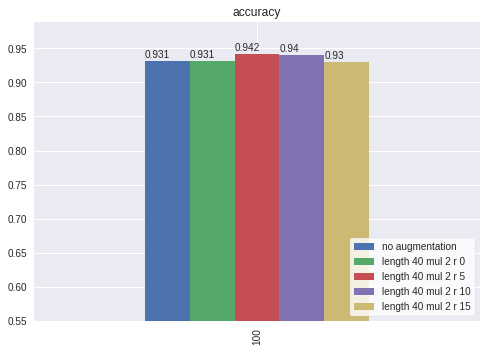

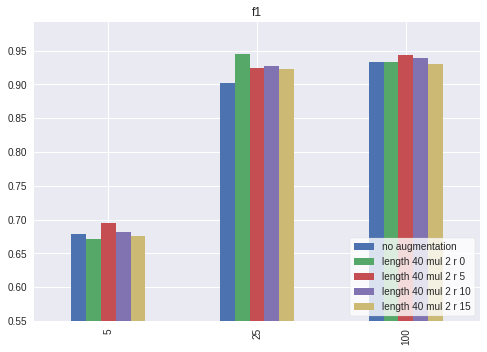

In [29]:
new_l40_m2_r5 = getDataFrameByDirectory([5,25,100], 'dataFrames/03_new/new_l40_m2_s5', 'length_40_mul_2_r_5')
new_l40_m2_r10 = getDataFrameByDirectory([5,25,100], 'dataFrames/03_new/new_l40_m2_s10', 'length_40_mul_2_r_10')
new_l40_m2_r15 = getDataFrameByDirectory([5,25,100], 'dataFrames/03_new/new_l40_m2_s15', 'length_40_mul_2_r_15')
plotByDataFrames([only, new_l40_m2_r0, new_l40_m2_r5, new_l40_m2_r10, new_l40_m2_r15], 'accuracy', 'bar', [100],show_values=True, create_mean=False, legend=True, ymin=0.55)
plotByDataFrames([only, new_l40_m2_r0, new_l40_m2_r5, new_l40_m2_r10, new_l40_m2_r15], 'f1', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.55)

## 7.2 Reinforcement Learning
Vergleich zwischen den beiden Base-Lines Supervised Learning und RL

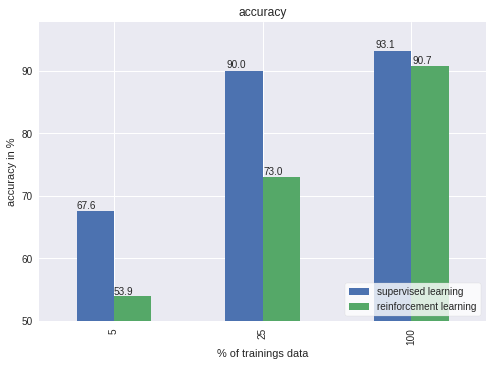

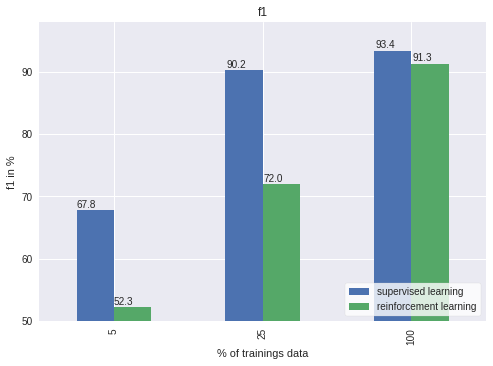

In [4]:
rl_only = getDataFrameByDirectory([5,25,100], './dataFrames/04_rl_only/only_v2', 'RL:_no_augmentation')
plotByDataFrames([only, rl_only], 'accuracy', 'bar', show_values=True, create_mean=False, legend=True, ymin=0.5, legend_title=['supervised learning', 'reinforcement learning'], save_path='rl_sl-accuracy.png')
plotByDataFrames([only, rl_only], 'f1', 'bar', show_values=True, create_mean=False, legend=True, ymin=0.5, legend_title=['supervised learning', 'reinforcement learning'], save_path='rl_sl-f1.png')

In [5]:
rl_only_5pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_5pr_conf', 'no_augmentation__5')
rl_only_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_10pr_conf', 'no_augmentation__10')
rl_only_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_15pr_conf', 'no_augmentation__15')
rl_only_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_20pr_conf', 'no_augmentation__20')
rl_only_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_25pr_conf', 'no_augmentation__25')
plotByDataFrames([only_5pr_conf, only_10pr_conf, only_15pr_conf, only_20pr_conf, only_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_only_5pr_conf, rl_only_10pr_conf, rl_only_15pr_conf, rl_only_20pr_conf, rl_only_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True,legend_title=['supervised learning', 'reinforcement learning'], save_path='rl_sl_graph-accuracy.png')
plt.show()
plotByDataFrames([only_5pr_conf, only_10pr_conf, only_15pr_conf, only_20pr_conf, only_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_only_5pr_conf, rl_only_10pr_conf, rl_only_15pr_conf, rl_only_20pr_conf, rl_only_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True,legend_title=['supervised learning', 'reinforcement learning'], save_path='rl_sl_graph-f1.png')

NameError: name 'only_5pr_conf' is not defined

### 7.2.1 Vertauschung
Identische Anzahl an Kopien mit unterschiedlicher Anzahl an Blöcken

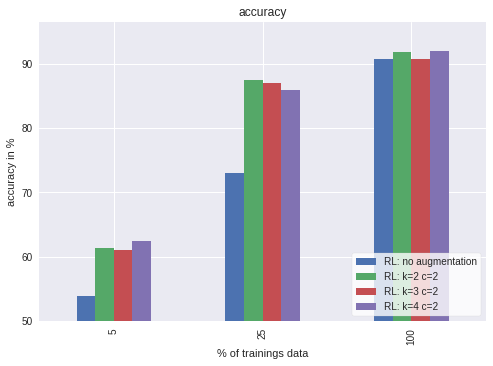

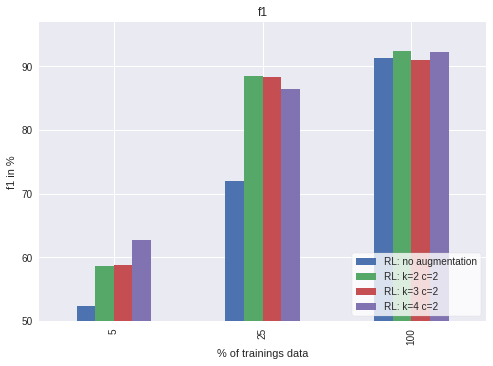

In [120]:
rl_b2_c2 = getDataFrameByDirectory([5,25,100], './dataFrames/05_rl_blocks/blocks_2_copies_2', 'RL:_k=2_c=2')
rl_b3_c2 = getDataFrameByDirectory([5,25,100], './dataFrames/05_rl_blocks/blocks_3_copies_2', 'RL:_k=3_c=2')
rl_b4_c2 = getDataFrameByDirectory([5,25,100], './dataFrames/05_rl_blocks/blocks_4_copies_2', 'RL:_k=4_c=2')
plotByDataFrames([rl_only, rl_b2_c2, rl_b3_c2, rl_b4_c2], 'accuracy', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.5, save_path='rl_blocks_2-4_copies_2-accuracy.png')
plotByDataFrames([rl_only, rl_b2_c2, rl_b3_c2, rl_b4_c2], 'f1', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.5, save_path='rl_blocks_2-4_copies_2-f1.png')

Variable Anzahl kopien mit 2 Blöcken

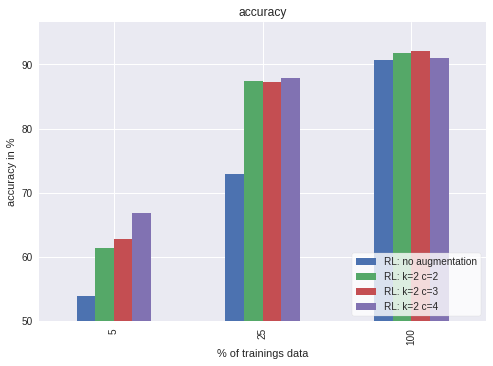

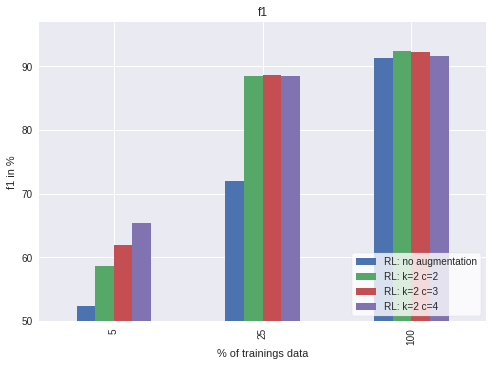

In [121]:
rl_b2_c3 = getDataFrameByDirectory([5,25,100], './dataFrames/05_rl_blocks/blocks_2_copies_3', 'RL:_k=2_c=3')
rl_b2_c4 = getDataFrameByDirectory([5,25,100], './dataFrames/05_rl_blocks/blocks_2_copies_4', 'RL:_k=2_c=4')
plotByDataFrames([rl_only, rl_b2_c2, rl_b2_c3, rl_b2_c4], 'accuracy', 'bar',show_values=False, create_mean=False, legend=True, ymin=0.5, save_path='rl_blocks_2_copies_2-4-accuracy.png')
plotByDataFrames([rl_only, rl_b2_c2, rl_b2_c3, rl_b2_c4], 'f1', 'bar', show_values=False, create_mean=False, legend=True, ymin=0.5, save_path='rl_blocks_2_copies_2-4-f1.png')

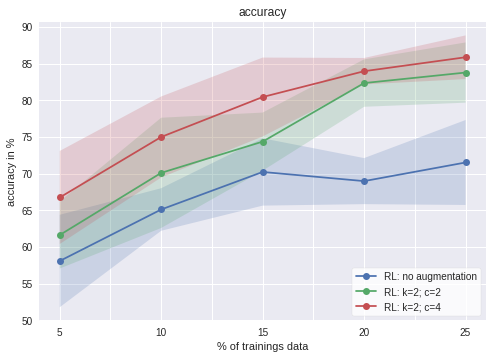

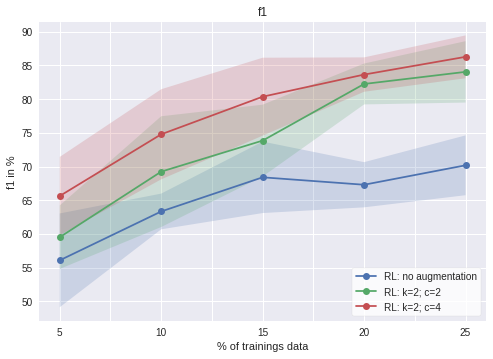

In [17]:
rl_b2_c2_5pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/05_rl_blocks/blocks_2_copies_2_5pr_conf', 'rl_blocks_2_copies_2__5')
rl_b2_c2_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/05_rl_blocks/blocks_2_copies_2_10pr_conf', 'rl_blocks_2_copies_2__10')
rl_b2_c2_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/05_rl_blocks/blocks_2_copies_2_15pr_conf', 'rl_blocks_2_copies_2__15')
rl_b2_c2_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/05_rl_blocks/blocks_2_copies_2_20pr_conf', 'rl_blocks_2_copies_2__20')
rl_b2_c2_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/05_rl_blocks/blocks_2_copies_2_25pr_conf', 'rl_blocks_2_copies_2__25')

rl_b2_c4_5pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/05_rl_blocks/blocks_2_copies_4_5pr_conf', 'rl_blocks_2_copies_4__5')
rl_b2_c4_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/05_rl_blocks/blocks_2_copies_4_10pr_conf', 'rl_blocks_2_copies_4__10')
rl_b2_c4_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/05_rl_blocks/blocks_2_copies_4_15pr_conf', 'rl_blocks_2_copies_4__15')
rl_b2_c4_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/05_rl_blocks/blocks_2_copies_4_20pr_conf', 'rl_blocks_2_copies_4__20')
rl_b2_c4_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/05_rl_blocks/blocks_2_copies_4_25pr_conf', 'rl_blocks_2_copies_4__25')

plotByDataFrames([rl_only_5pr_conf, rl_only_10pr_conf, rl_only_15pr_conf, rl_only_20pr_conf, rl_only_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_b2_c2_5pr_conf, rl_b2_c2_10pr_conf, rl_b2_c2_15pr_conf, rl_b2_c2_20pr_conf, rl_b2_c2_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_b2_c4_5pr_conf, rl_b2_c4_10pr_conf, rl_b2_c4_15pr_conf, rl_b2_c4_20pr_conf, rl_b2_c4_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True,legend_title=['RL: no augmentation', 'RL: k=2; c=2', 'RL: k=2; c=4'],save_path='rl_blocks_graph-accuracy.png')

plt.show()
plotByDataFrames([rl_only_5pr_conf, rl_only_10pr_conf, rl_only_15pr_conf, rl_only_20pr_conf, rl_only_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_b2_c2_5pr_conf, rl_b2_c2_10pr_conf, rl_b2_c2_15pr_conf, rl_b2_c2_20pr_conf, rl_b2_c2_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_b2_c4_5pr_conf, rl_b2_c4_10pr_conf, rl_b2_c4_15pr_conf, rl_b2_c4_20pr_conf, rl_b2_c4_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True,legend_title=['RL: no augmentation', 'RL: k=2; c=2', 'RL: k=2; c=4'],save_path='rl_blocks_graph-f1.png')

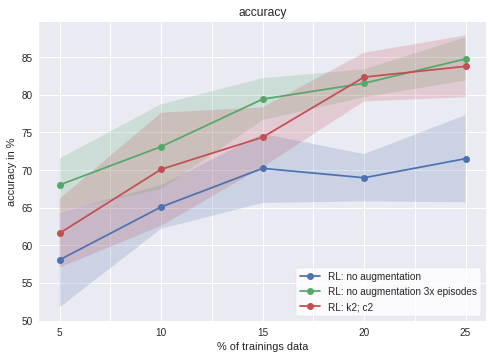

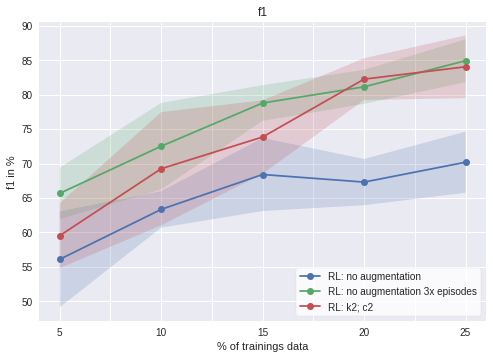

In [18]:
rl_only_3c_5pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_3_copies_5pr_conf', 'no_augmentation__5')
rl_only_3c_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_3_copies_10pr_conf', 'no_augmentation__10')
rl_only_3c_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_3_copies_15pr_conf', 'no_augmentation__15')
rl_only_3c_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_3_copies_20pr_conf', 'no_augmentation__20')
rl_only_3c_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_3_copies_25pr_conf', 'no_augmentation__25')

plotByDataFrames([rl_only_5pr_conf, rl_only_10pr_conf, rl_only_15pr_conf, rl_only_20pr_conf, rl_only_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_only_3c_5pr_conf, rl_only_3c_10pr_conf, rl_only_3c_15pr_conf, rl_only_3c_20pr_conf, rl_only_3c_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_b2_c2_5pr_conf, rl_b2_c2_10pr_conf, rl_b2_c2_15pr_conf, rl_b2_c2_20pr_conf, rl_b2_c2_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True,legend_title=['RL: no augmentation', 'RL: no augmentation 3x episodes', 'RL: k2; c2'], save_path='rl_blocks_graph_ablatation-accuracy.png')

plt.show()
plotByDataFrames([rl_only_5pr_conf, rl_only_10pr_conf, rl_only_15pr_conf, rl_only_20pr_conf, rl_only_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_only_3c_5pr_conf, rl_only_3c_10pr_conf, rl_only_3c_15pr_conf, rl_only_3c_20pr_conf, rl_only_3c_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_b2_c2_5pr_conf, rl_b2_c2_10pr_conf, rl_b2_c2_15pr_conf, rl_b2_c2_20pr_conf, rl_b2_c2_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True,legend_title=['RL: no augmentation', 'RL: no augmentation 3x episodes', 'RL: k2; c2'], save_path='rl_blocks_graph_ablatation-f1.png')

### 7.2.2 Chitchat

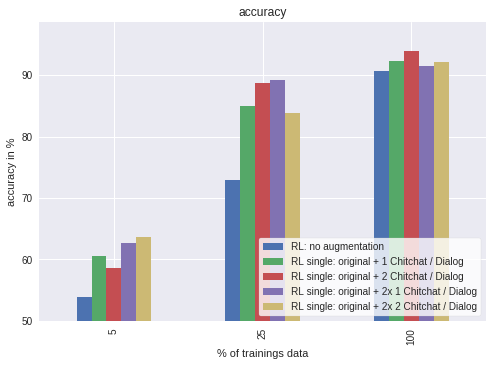

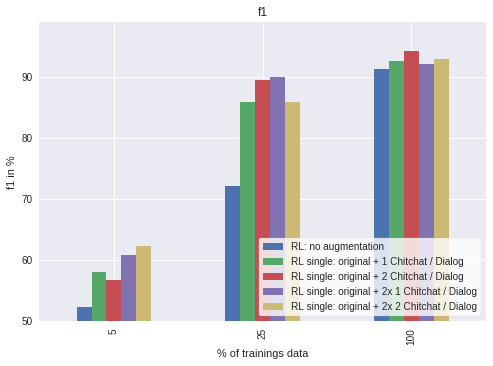

In [6]:
rl_single_s2_c1 =getDataFrameByDirectory([5,25,100], './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_2', 'RL_single:_original_+_2_Chitchat_/_Dialog')
rl_single_s1_c1 =getDataFrameByDirectory([5,25,100], './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_1', 'RL_single:_original_+_1_Chitchat_/_Dialog')
rl_single_s2_c2 =getDataFrameByDirectory([5,25,100], './dataFrames/06_rl_chitchat/single_original_t_copies_2_stories_2', 'RL_single:_original_+_2x_2_Chitchat_/_Dialog')
rl_single_s1_c2 =getDataFrameByDirectory([5,25,100], './dataFrames/06_rl_chitchat/single_original_t_copies_2_stories_1', 'RL_single:_original_+_2x_1_Chitchat_/_Dialog')
plotByDataFrames([rl_only, rl_single_s1_c1, rl_single_s2_c1, rl_single_s1_c2, rl_single_s2_c2], 'accuracy', 'bar', show_values=False, legend=True, ymin=0.5, save_path='rl_cc_single_s1-2_c1-2_ot-accuracy.png')
plotByDataFrames([rl_only, rl_single_s1_c1, rl_single_s2_c1, rl_single_s1_c2, rl_single_s2_c2], 'f1', 'bar',show_values=False, legend=True, ymin=0.5, save_path='rl_cc_single_s1-2_c1-2_ot-f1.png')

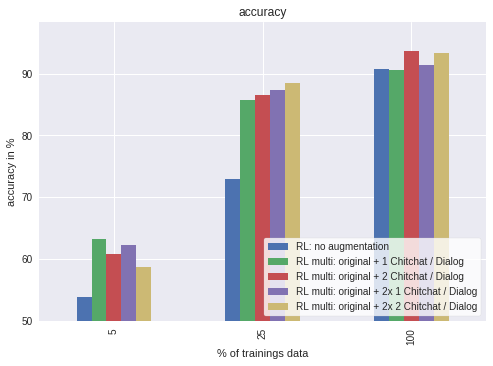

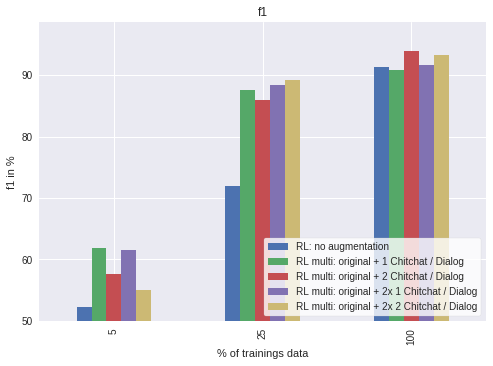

In [126]:
rl_multi_s2_c1 =getDataFrameByDirectory([5,25,100], './dataFrames/06_rl_chitchat/multi_original_t_copies_1_stories_2', 'RL_multi:_original_+_2_Chitchat_/_Dialog')
rl_multi_s1_c1 =getDataFrameByDirectory([5,25,100], './dataFrames/06_rl_chitchat/multi_original_t_copies_1_stories_1', 'RL_multi:_original_+_1_Chitchat_/_Dialog')
rl_multi_s2_c2 =getDataFrameByDirectory([5,25,100], './dataFrames/06_rl_chitchat/multi_original_t_copies_2_stories_2', 'RL_multi:_original_+_2x_2_Chitchat_/_Dialog')
rl_multi_s1_c2 =getDataFrameByDirectory([5,25,100], './dataFrames/06_rl_chitchat/multi_original_t_copies_2_stories_1', 'RL_multi:_original_+_2x_1_Chitchat_/_Dialog')
plotByDataFrames([rl_only, rl_multi_s1_c1, rl_multi_s2_c1, rl_multi_s1_c2, rl_multi_s2_c2], 'accuracy', 'bar', show_values=False, legend=True, ymin=0.5, save_path='rl_cc_multi_s1-2_c1-2_ot-accuracy.png')
plotByDataFrames([rl_only, rl_multi_s1_c1, rl_multi_s2_c1, rl_multi_s1_c2, rl_multi_s2_c2], 'f1', 'bar',  show_values=False, legend=True, ymin=0.5, save_path='rl_cc_multi_s1-2_c1-2_ot-f1.png')

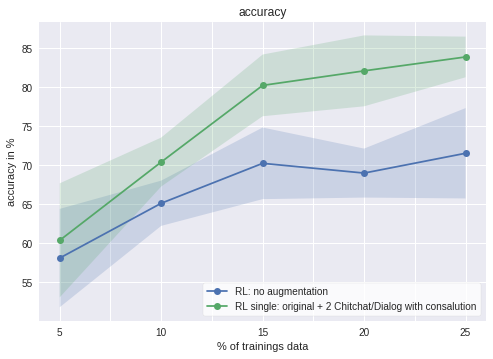

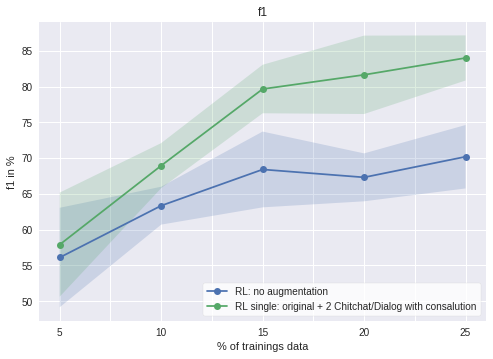

In [19]:
rl_single_c1_s2_5pr_conf = getDataFrameByDirectory([1,2,3,4,5],  './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_2_5pr_conf', 'RL_single:_original_+_2_Chitchat_/_Dialog__5')
rl_single_c1_s2_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_2_10pr_conf', 'RL_single:_original_+_2_Chitchat_/_Dialog__10')
rl_single_c1_s2_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_2_15pr_conf', 'RL_single:_original_+_2_Chitchat_/_Dialog__15')
rl_single_c1_s2_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_2_20pr_conf', 'RL_single:_original_+_2_Chitchat_/_Dialog__20')
rl_single_c1_s2_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_2_25pr_conf', 'RL_single:_original_+_2_Chitchat_/_Dialog__25')
plotByDataFrames([rl_only_5pr_conf, rl_only_10pr_conf, rl_only_15pr_conf, rl_only_20pr_conf, rl_only_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_single_c1_s2_5pr_conf, rl_single_c1_s2_10pr_conf, rl_single_c1_s2_15pr_conf, rl_single_c1_s2_20pr_conf, rl_single_c1_s2_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True,legend_title=['RL: no augmentation', 'RL single: original + 2 Chitchat/Dialog with consalution'], save_path='rl_chitchat_ot_c1_s2_graph-accuracy.png')
plt.show()
plotByDataFrames([rl_only_5pr_conf, rl_only_10pr_conf, rl_only_15pr_conf, rl_only_20pr_conf, rl_only_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
rl_only_3c_5pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_3_copies_5pr_conf', 'no_augmentation__5')
rl_only_3c_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_3_copies_10pr_conf', 'no_augmentation__10')
rl_only_3c_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_3_copies_15pr_conf', 'no_augmentation__15')
rl_only_3c_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_3_copies_20pr_conf', 'no_augmentation__20')
rl_only_3c_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_3_copies_25pr_conf', 'no_augmentation__25')
plotByDataFrames([rl_single_c1_s2_5pr_conf, rl_single_c1_s2_10pr_conf, rl_single_c1_s2_15pr_conf, rl_single_c1_s2_20pr_conf, rl_single_c1_s2_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True, legend_title=['RL: no augmentation','RL single: original + 2 Chitchat/Dialog with consalution'], save_path='rl_chitchat_ot_c1_s2_graph-f1.png')

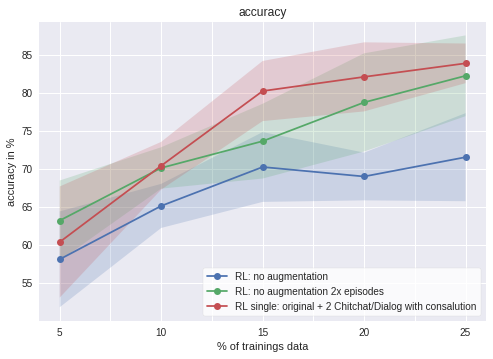

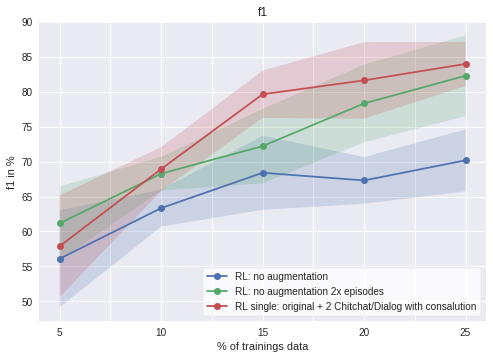

In [20]:
rl_only_2c_5pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_2_copies_5pr_conf', 'no_augmentation__5')
rl_only_2c_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_2_copies_10pr_conf', 'no_augmentation__10')
rl_only_2c_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_2_copies_15pr_conf', 'no_augmentation__15')
rl_only_2c_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_2_copies_20pr_conf', 'no_augmentation__20')
rl_only_2c_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/04_rl_only/only_2_copies_25pr_conf', 'no_augmentation__25')

rl_single_c1_s2_5pr_conf = getDataFrameByDirectory([1,2,3,4,5],  './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_2_5pr_conf', 'RL_single:_original_+_2_Chitchat_/_Dialog__5')
rl_single_c1_s2_10pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_2_10pr_conf', 'RL_single:_original_+_2_Chitchat_/_Dialog__10')
rl_single_c1_s2_15pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_2_15pr_conf', 'RL_single:_original_+_2_Chitchat_/_Dialog__15')
rl_single_c1_s2_20pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_2_20pr_conf', 'RL_single:_original_+_2_Chitchat_/_Dialog__20')
rl_single_c1_s2_25pr_conf = getDataFrameByDirectory([1,2,3,4,5], './dataFrames/06_rl_chitchat/single_original_t_copies_1_stories_2_25pr_conf', 'RL_single:_original_+_2_Chitchat_/_Dialog__25')
plotByDataFrames([rl_only_5pr_conf, rl_only_10pr_conf, rl_only_15pr_conf, rl_only_20pr_conf, rl_only_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_only_2c_5pr_conf, rl_only_2c_10pr_conf, rl_only_2c_15pr_conf, rl_only_2c_20pr_conf, rl_only_2c_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_single_c1_s2_5pr_conf, rl_single_c1_s2_10pr_conf, rl_single_c1_s2_15pr_conf, rl_single_c1_s2_20pr_conf, rl_single_c1_s2_25pr_conf], 'accuracy', 'line', show_values=False, legend=True, create_mean=True,legend_title=['RL: no augmentation', 'RL: no augmentation 2x episodes', 'RL single: original + 2 Chitchat/Dialog with consalution'], save_path='rl_chitchat_graph_ablation-accuracy.png')
plt.show()
plotByDataFrames([rl_only_5pr_conf, rl_only_10pr_conf, rl_only_15pr_conf, rl_only_20pr_conf, rl_only_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_only_2c_5pr_conf, rl_only_2c_10pr_conf, rl_only_2c_15pr_conf, rl_only_2c_20pr_conf, rl_only_2c_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True)
plotByDataFrames([rl_single_c1_s2_5pr_conf, rl_single_c1_s2_10pr_conf, rl_single_c1_s2_15pr_conf, rl_single_c1_s2_20pr_conf, rl_single_c1_s2_25pr_conf], 'f1', 'line', show_values=False, legend=True, create_mean=True, legend_title=['RL: no augmentation', 'RL: no augmentation 2x episodes','RL single: original + 2 Chitchat/Dialog with consalution'], save_path='rl_chitchat_graph_ablation-f1.png')

#### Signifikanztests

Für 10\% der Daten

In [55]:
significantTest(rl_only_2c_10pr_conf['no_augmentation__10_accuracy'],rl_single_c1_s2_10pr_conf['RL_single:_original_+_2_Chitchat_/_Dialog__10_accuracy'])
significantTest(rl_only_2c_10pr_conf['no_augmentation__10_f1'],rl_single_c1_s2_10pr_conf['RL_single:_original_+_2_Chitchat_/_Dialog__10_f1'])

x=0.701+-0.027
y=0.703+-0.031
stat=-0.192, p=0.853
Probably the same distribution
x=0.682+-0.024
y=0.689+-0.031
stat=-0.464, p=0.655
Probably the same distribution


In [69]:
significantTest(rl_only_25pr_conf['no_augmentation__25_f1'],rl_single_c1_s2_25pr_conf['RL_single:_original_+_2_Chitchat_/_Dialog__25_accuracy'])

x=0.701+-0.044
y=0.838+-0.026
stat=-7.385, p=0.000
Probably different distributions


**Für 15\% der Daten**

In [56]:
significantTest(rl_only_2c_15pr_conf['no_augmentation__15_accuracy'],rl_single_c1_s2_15pr_conf['RL_single:_original_+_2_Chitchat_/_Dialog__15_accuracy'])
significantTest(rl_only_2c_15pr_conf['no_augmentation__15_f1'],rl_single_c1_s2_15pr_conf['RL_single:_original_+_2_Chitchat_/_Dialog__15_f1'])

x=0.736+-0.049
y=0.802+-0.039
stat=-2.901, p=0.020
Probably different distributions
x=0.722+-0.053
y=0.796+-0.033
stat=-3.266, p=0.011
Probably different distributions


**Für 20\% der Daten**

In [57]:
significantTest(rl_only_2c_20pr_conf['no_augmentation__20_accuracy'],rl_single_c1_s2_20pr_conf['RL_single:_original_+_2_Chitchat_/_Dialog__20_accuracy'])
significantTest(rl_only_2c_20pr_conf['no_augmentation__20_f1'],rl_single_c1_s2_20pr_conf['RL_single:_original_+_2_Chitchat_/_Dialog__20_f1'])

x=0.787+-0.064
y=0.82+-0.045
stat=-1.181, p=0.272
Probably the same distribution
x=0.783+-0.055
y=0.816+-0.054
stat=-1.175, p=0.274
Probably the same distribution


**Für 25\% der Daten**

In [59]:
significantTest(rl_only_2c_25pr_conf['no_augmentation__25_accuracy'],rl_single_c1_s2_25pr_conf['RL_single:_original_+_2_Chitchat_/_Dialog__25_accuracy'])
significantTest(rl_only_2c_25pr_conf['no_augmentation__25_f1'],rl_single_c1_s2_25pr_conf['RL_single:_original_+_2_Chitchat_/_Dialog__25_f1'])

x=0.822+-0.053
y=0.838+-0.026
stat=-0.769, p=0.464
Probably the same distribution
x=0.823+-0.057
y=0.839+-0.031
stat=-0.715, p=0.495
Probably the same distribution


### 7.2.3 Generierung anhand des Graphen $G$ ohne original Dialoge

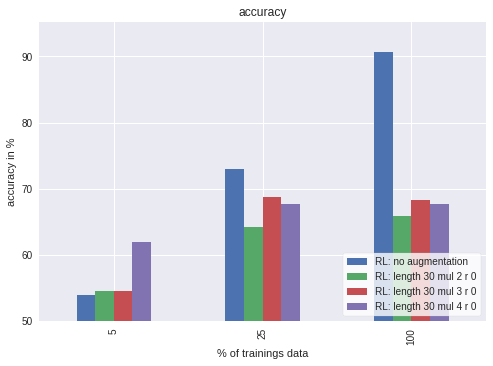

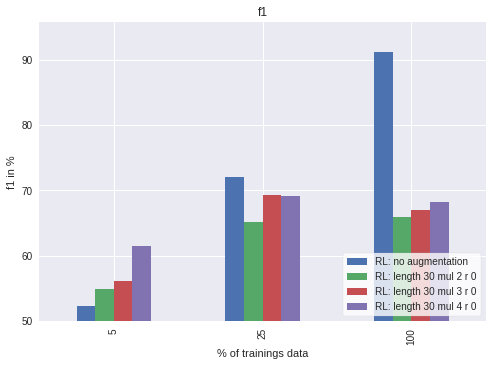

In [132]:
rl_new_l30_m2_r0 = getDataFrameByDirectory([5,25,100], './dataFrames/07_rl_new/new_l30_m2_r0', 'RL:_length_30_mul_2_r_0')
rl_new_l30_m3_r0 = getDataFrameByDirectory([5,25,100], './dataFrames/07_rl_new/new_l30_m3_r0', 'RL:_length_30_mul_3_r_0')
rl_new_l30_m4_r0 = getDataFrameByDirectory([5,25,100], './dataFrames/07_rl_new/new_l30_m4_r0', 'RL:_length_30_mul_4_r_0')
plotByDataFrames([rl_only, rl_new_l30_m2_r0, rl_new_l30_m3_r0,rl_new_l30_m4_r0], 'accuracy', 'bar', show_values=False, legend=True, ymin=0.5, save_path='rl_new_l30_m2-4_r0_of-accuracy.png')
plotByDataFrames([rl_only, rl_new_l30_m2_r0, rl_new_l30_m3_r0,rl_new_l30_m4_r0], 'f1', 'bar', show_values=False, legend=True, ymin=0.5, save_path='rl_new_l30_m2-4_r0_of-f1')

Generierung mit original Dialogen

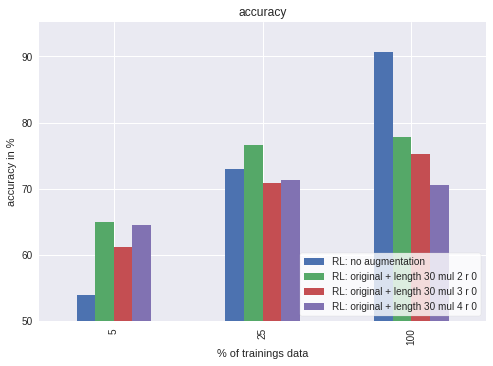

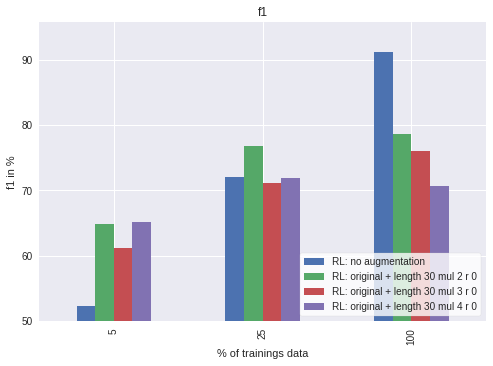

In [134]:
rl_new_l30_m2_r0_ot = getDataFrameByDirectory([5,25,100], './dataFrames/07_rl_new/new_l30_m2_r0_ot', 'RL:_original_+_length_30_mul_2_r_0')
rl_new_l30_m3_r0_ot = getDataFrameByDirectory([5,25,100], './dataFrames/07_rl_new/new_l30_m3_r0_ot', 'RL:_original_+_length_30_mul_3_r_0')
rl_new_l30_m4_r0_ot = getDataFrameByDirectory([5,25,100], './dataFrames/07_rl_new/new_l30_m4_r0_ot', 'RL:_original_+_length_30_mul_4_r_0')
plotByDataFrames([rl_only, rl_new_l30_m2_r0_ot, rl_new_l30_m3_r0_ot,rl_new_l30_m4_r0_ot], 'accuracy', 'bar', show_values=False, legend=True, ymin=0.5, save_path='rl_new_l30_m2-4_r0_ot-accuracy')
plotByDataFrames([rl_only, rl_new_l30_m2_r0_ot, rl_new_l30_m3_r0_ot,rl_new_l30_m4_r0_ot], 'f1', 'bar', show_values=False, legend=True, ymin=0.5, save_path='rl_new_l30_m2-4_r0_ot-f1')

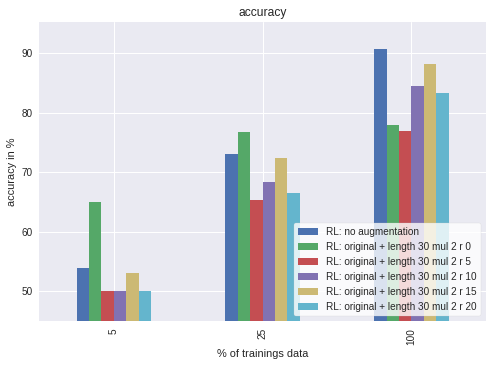

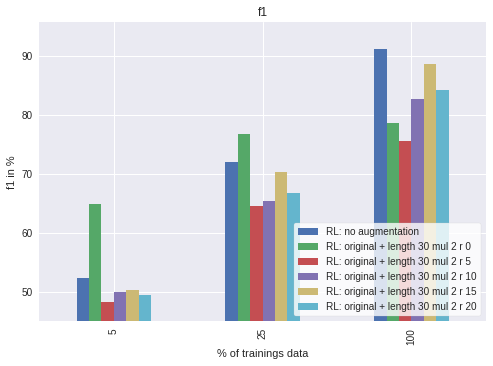

In [137]:
rl_new_l30_m2_r5_ot = getDataFrameByDirectory([5,25,100], './dataFrames/07_rl_new/new_l30_m2_r5_ot', 'RL:_original_+_length_30_mul_2_r_5')
rl_new_l30_m2_r10_ot = getDataFrameByDirectory([5,25,100], './dataFrames/07_rl_new/new_l30_m2_r10_ot', 'RL:_original_+_length_30_mul_2_r_10')
rl_new_l30_m2_r15_ot = getDataFrameByDirectory([5,25,100], './dataFrames/07_rl_new/new_l30_m2_r15_ot', 'RL:_original_+_length_30_mul_2_r_15')
rl_new_l30_m2_r20_ot = getDataFrameByDirectory([5,25,100], './dataFrames/07_rl_new/new_l30_m2_r20_ot', 'RL:_original_+_length_30_mul_2_r_20')
plotByDataFrames([rl_only, rl_new_l30_m2_r0_ot, rl_new_l30_m2_r5_ot, rl_new_l30_m2_r10_ot, rl_new_l30_m2_r15_ot, rl_new_l30_m2_r20_ot], 'accuracy', 'bar', show_values=False, legend=True, ymin=0.45, save_path='rl_new_l30_m2_r0-15_ot-accuracy.png')
plotByDataFrames([rl_only, rl_new_l30_m2_r0_ot, rl_new_l30_m2_r5_ot, rl_new_l30_m2_r10_ot, rl_new_l30_m2_r15_ot, rl_new_l30_m2_r20_ot], 'f1', 'bar', show_values=False, legend=True, ymin=0.45, save_path='rl_new_l30_m2_r0-15_ot-f1.png')


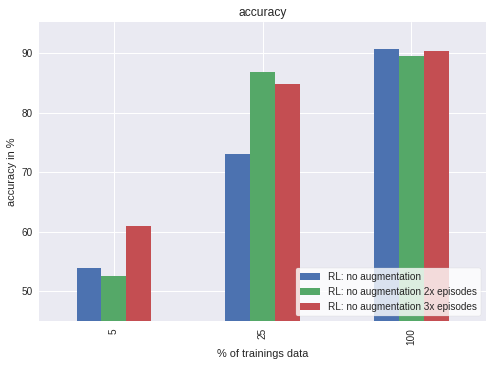

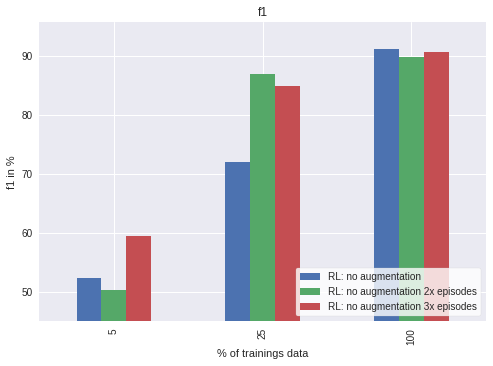

In [135]:
rl_only_2c = getDataFrameByDirectory([5,25,100], './dataFrames/04_rl_only/only_2_copies', 'RL:_no_augmentation_2x_episodes')
rl_only_3c = getDataFrameByDirectory([5,25,100], './dataFrames/04_rl_only/only_3_copies', 'RL:_no_augmentation_3x_episodes')
plotByDataFrames([rl_only, rl_only_2c, rl_only_3c], 'accuracy', 'bar', show_values=False, legend=True, ymin=0.45)
plotByDataFrames([rl_only, rl_only_2c, rl_only_3c], 'f1', 'bar', show_values=False, legend=True, ymin=0.45)
